<a href="https://colab.research.google.com/github/kschoi93/AI/blob/master/dacon_audio_classification_sr_16000_aug_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 및 환경설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torch.nn.functional as Functional
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import pandas as pd
import librosa
import librosa.display as dsp
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import random
import gc
import numpy as np
import random

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)


seed_everything(42)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
path = '/content/drive/MyDrive/dacon'
train_dir_path = f'{path}/train/'
test_dir_path = f'{path}/test/'

train_path = f'{path}/train.csv'
test_path = f'{path}/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 데이터 확인

In [ ]:
file_path = train_dir_path + train_df.file_name[2]
metadata = torchaudio.info(file_path)
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=30983, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
def print_stats(waveform, sample_rate):
    print('Sample Rate:', sample_rate)
    print('Shape: ', tuple(waveform.shape))
    print('Length: {0:.2f} secs'.format(waveform.shape[1] / float(sample_rate)))
    print('\n')
  
def plot_waveform(waveform, sample_rate, title='Waveform'):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    figure, axes = plt.subplots(num_channels, 1)
    axes.grid(True)
    axes.plot(time_axis, waveform[0], linewidth=1)
    figure.suptitle(title)
    plt.show(block=False)
    print('\n')

def plot_specgram(waveform, sample_rate, title='Spectrogram'):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    axes.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    plt.show(block=False)
    print('\n')

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    ipd.display(ipd.Audio(waveform[0], rate=sample_rate))
    print('\n')

In [ ]:
waveform, sample_rate= torchaudio.load(file_path)

Sample Rate: 48000
Shape:  (1, 30983)
Length: 0.65 secs




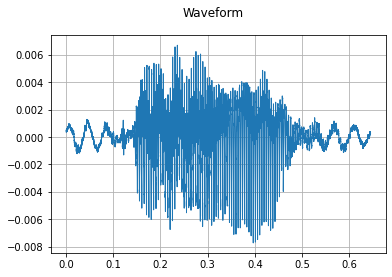

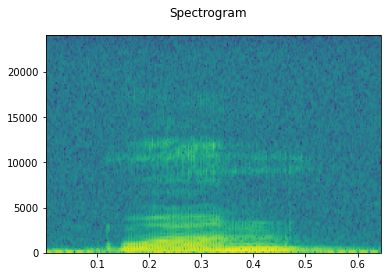

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

## Spectrogram

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
)

spec = spectrogram(waveform)
print(waveform.shape)
print(spec.shape)

torch.Size([1, 30983])
torch.Size([1, 513, 61])


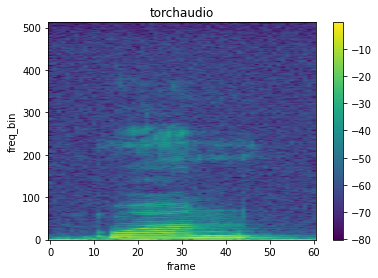

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.set_title('torchaudio')
axs.set_ylabel('freq_bin')
axs.set_xlabel('frame')
im = axs.imshow(librosa.power_to_db(spec[0]), origin='lower', aspect='auto')
fig.colorbar(im, ax=axs)
plt.show(block=False)

## Mel Filter Bank

torch.Size([129, 64])


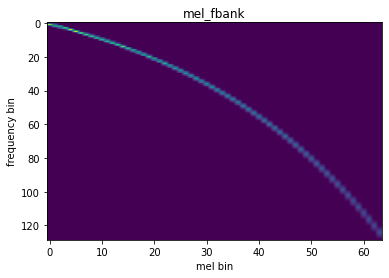

In [ ]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.,
    f_max=sample_rate/2.,
    sample_rate=sample_rate,
    norm='slaney'
)
print(mel_filters.shape)

fig, axs = plt.subplots(1,1)
axs.set_title('mel_fbank')
axs.imshow(mel_filters, aspect='auto')
axs.set_ylabel('frequency bin')
axs.set_xlabel('mel bin')
plt.show(block=False)

## MelSpectrogram

torch.Size([1, 128, 61])


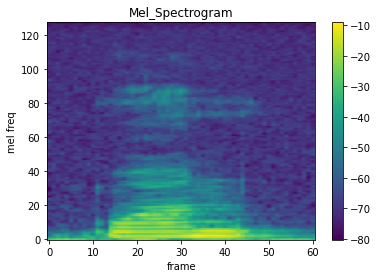

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale='htk'
)

melspec = mel_spectrogram(waveform)
print(melspec.shape)

fig, axs = plt.subplots(1, 1)
axs.set_title('Mel_Spectrogram')
axs.set_ylabel('mel freq')
axs.set_xlabel('frame')
im = axs.imshow(librosa.power_to_db(melspec[0]), origin='lower', aspect='auto')
fig.colorbar(im, ax=axs)
plt.show(block=False)

## MFCC

torch.Size([1, 256, 61])
tensor([[[-8.4668e+02, -8.3414e+02, -8.3095e+02,  ..., -8.3004e+02,
          -8.3321e+02, -8.4254e+02],
         [ 1.1400e-01,  1.1087e+01,  1.6501e+01,  ...,  9.8606e+00,
           7.3307e+00,  9.8273e+00],
         [ 1.8580e+01,  2.5558e+01,  3.3466e+01,  ...,  2.9402e+01,
           2.7593e+01,  3.0705e+01],
         ...,
         [ 2.3050e+00, -9.7913e-01, -1.0687e+00,  ..., -7.3438e-01,
          -2.2333e+00,  8.8297e-01],
         [-1.4807e+00,  1.9869e+00,  2.9897e+00,  ...,  3.4580e-01,
          -1.6510e+00, -2.6891e+00],
         [ 8.3568e-01,  1.6300e+00,  3.0627e+00,  ...,  2.0485e+00,
           3.8061e-01, -1.4779e+00]]])


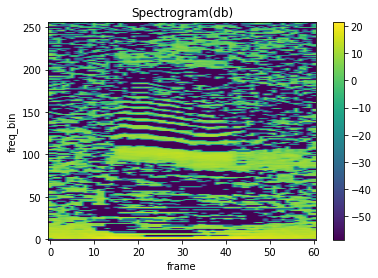

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        'n_fft': n_fft,
        'n_mels': n_mels,
        'hop_length':hop_length,
        'mel_scale':'htk',
    }
)

mfcc = mfcc_transform(waveform)
print(mfcc.shape)
print(mfcc)
fig, axs = plt.subplots(1, 1)
axs.set_title('Spectrogram(db)')
axs.set_ylabel('freq_bin')
axs.set_xlabel('frame')
im = axs.imshow(librosa.power_to_db(mfcc[0]), origin='lower',aspect='auto')
fig.colorbar(im, ax=axs)
plt.show()

# 데이터 불러오기, 전처리

In [ ]:
# 고정값
sr = 16000
pad_num = 70

In [ ]:
print(train_df.head())
print(test_df.head())

  file_name  label
0   001.wav      9
1   002.wav      0
2   004.wav      1
3   005.wav      8
4   006.wav      0
  file_name
0   003.wav
1   008.wav
2   010.wav
3   015.wav
4   024.wav


In [ ]:
def preprocessing_mfcc(resample_data):
    n_fft = 2048
    win_length = None
    hop_length = 512
    n_mels = 256
    n_mfcc = 256

    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc = n_mfcc,
        melkwargs={
            'n_fft': n_fft,
            'n_mels': n_mels,
            'hop_length': hop_length,
            'mel_scale': 'htk',
        }
    )

    mfcc = mfcc_transform(resample_data)
    return mfcc

In [ ]:
def preprocessing_pad(mfcc_data):
    pad_length = pad_num - mfcc_data.shape[2]
    left = random.randrange(1, pad_length + 1)
    rigth = pad_length - left
    sp = (left, rigth)
    # pad_length = pad_num - mfcc_data.shape[2]
    # sp = (pad_length, 0)
    result = Functional.pad(input=mfcc_data, pad=sp, mode='constant', value=0)
    return result

In [ ]:
def make_dataframe(df, dir_path):
    dataset = pd.DataFrame()
    
    audios_train = []
    labels_train = []
    audios_test = []

    mfcc_data = []
    max_shape = 0

    # path setting
    if dir_path == 'train':
        dir_path = train_dir_path
    else:
        dir_path = test_dir_path
    

    # load file
    for i in tqdm(range(df.file_name.size)):
        audio = torchaudio.load( f'{dir_path}/{df.file_name[i]}')
        # resampler setting 48000 -> 16000
        original_sample_rate = audio[1]
        resampler = T.Resample(orig_freq=original_sample_rate, new_freq=sr)
        # resample data
        audio_data = audio[0]
        resample_data = resampler(audio_data)
        # preprocessing
        ## extract mfcc feature
        mfcc = preprocessing_mfcc(resample_data)
        mfcc_data.append(mfcc)
        ## modification pad, create 5 data
        if 'train' in dir_path:    
            for j in range(11):
                modify_pad = preprocessing_pad(mfcc)
                # add audios
                audios_train.append(modify_pad)
                labels_train.append(df.label[i])
        else:
            modify_pad = preprocessing_pad(mfcc)
            audios_test.append(modify_pad)
    
    if 'train' in dir_path:
        dataset['audio'] = audios_train
        dataset['label'] = labels_train  
        # drawing 
        index = 0
        fig, axes = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
        for i in range(3):
            for j in range(3):
                axes[i, j].set_title(dataset.label[index])
                axes[i, j].set_ylabel('freq_bin')
                axes[i, j].set_xlabel('frame')
                im = axes[i,j].imshow(librosa.power_to_db(torch.squeeze(mfcc_data[index])), origin='lower', aspect='auto')
                fig.colorbar(im, ax=axs)        
                index+=1
        plt.show()
    else:
        dataset['audio'] = audios_test
    return dataset

100%|██████████| 400/400 [00:12<00:00, 33.10it/s]


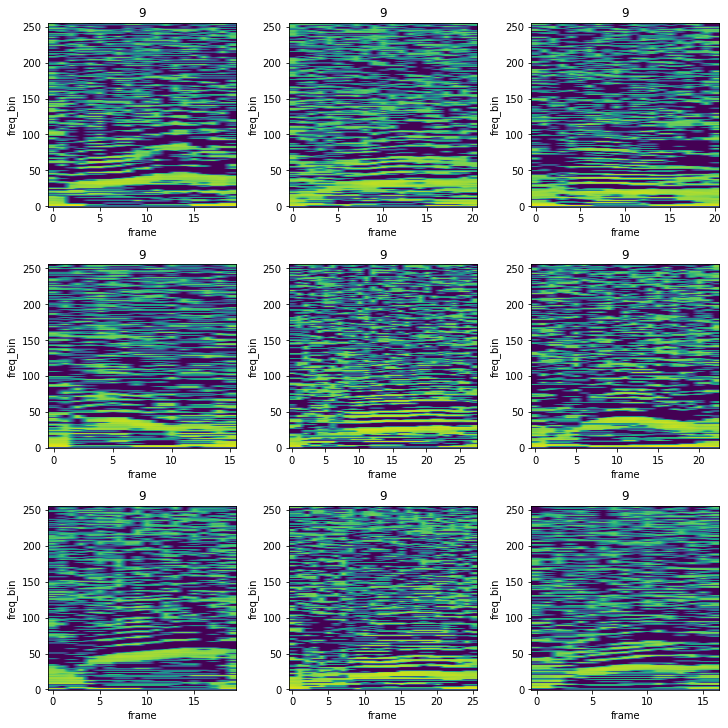

100%|██████████| 200/200 [00:04<00:00, 44.43it/s]


In [ ]:
train_dataframe = make_dataframe(train_df, 'train')
test_dataframe = make_dataframe(test_df, 'test')

In [ ]:
train_dataframe.head()

,audio,label
0,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",9
1,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",9
2,"[[[tensor(0.), tensor(0.), tensor(-834.8425), ...",9
3,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",9
4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",9


In [ ]:
train_dataframe.audio[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
test_dataframe.audio[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
train_dataframe.audio[0].shape

torch.Size([1, 256, 70])

# 데이터셋 만들기

In [ ]:
# 고정값
lr = 1e-3
epochs = 20
batch_size = 8
num_worker = 0

In [ ]:
class CustomAudioDataset(Dataset):
    def __init__(self, df, file_type):
        self.audio = df.iloc[:,0].values
        if file_type == 'train':
            self.label = df.iloc[:,1].values
        self.file_type = file_type

    def __len__(self):
        return len(self.audio)

    def __getitem__(self, idx):
        if self.file_type == 'train':
            return self.audio[idx], self.label[idx]
        else:
            return self.audio[idx]

In [ ]:
# create dataset
origin_dataset = CustomAudioDataset(train_dataframe, 'train')
test_dataset = CustomAudioDataset(test_dataframe, 'test')

# split dataset
train_size = int(0.9 * len(origin_dataset))
test_size = len(origin_dataset) - train_size
train_dataset, valid_dataset = random_split(origin_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_worker)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_worker)

In [ ]:
# original dataset 400
print(len(train_dataloader) * batch_size)
print(len(valid_dataloader) * batch_size)
# test dataset 200
print(len(test_dataloader) * batch_size)

3960
440
200


# 모델 만들기

In [ ]:
class AudioClassificationCNN(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=1, n_channel=32):
        super(AudioClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=6, stride=stride)
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(6)

        self.conv2 = nn.Conv2d(n_channel, n_channel*2, kernel_size=5, stride=stride)
        self.bn2 = nn.BatchNorm2d(n_channel*2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(5)

        self.fc1 = nn.Linear(448 , 1600)
        self.fc2 = nn.Linear(1600, 500)
        self.fc3 = nn.Linear(500, n_output)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = AudioClassificationCNN()
model.to(device)

AudioClassificationCNN(
  (conv1): Conv2d(1, 32, kernel_size=(6, 6), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=448, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
torch.cuda.empty_cache()
def train(model, epochs):
    total_loss, total_val_loss = 0, 0
    correct_pred = 0
    total_pred = 0
    for epoch in range(epochs):
        gc.collect()
        model.train()
        tqdm_dataset = tqdm(enumerate(train_dataloader))
        for batch, (audios, labels) in tqdm_dataset:
            # setting device
            audios, labels = audios.to(device), labels.to(device)
            output = model(audios)
            # loss & optimizer
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Lr': lr,
                'Loss': loss.item(),
                'Total Loss': '{:04f}'.format(total_loss / (batch+1))
            })
    
        model.eval()
        tqdm_dataset = tqdm(enumerate(valid_dataloader))
        for batch, (audios, labels) in tqdm_dataset:
            with torch.no_grad():
                audios, labels = audios.to(device), labels.to(device)
                output = model(audios)
                _, predictions = torch.max(output, 1)
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred += 1
                    total_pred += 1
                tqdm_dataset.set_postfix({
                    'Epoch': epoch + 1,
                    'Lr': lr,
                    'accuracy': correct_pred/total_pred,
                })

In [ ]:
train(model, epochs)

495it [01:30,  5.49it/s, Epoch=1, Lr=0.001, Loss=1.04, Total Loss=1.641046]
55it [00:02, 21.13it/s, Epoch=1, Lr=0.001, accuracy=0.718]
495it [01:23,  5.96it/s, Epoch=2, Lr=0.001, Loss=0.648, Total Loss=2.472056]
55it [00:02, 21.60it/s, Epoch=2, Lr=0.001, accuracy=0.783]
495it [01:22,  5.97it/s, Epoch=3, Lr=0.001, Loss=0.637, Total Loss=2.992923]
55it [00:02, 21.50it/s, Epoch=3, Lr=0.001, accuracy=0.813]
495it [01:20,  6.12it/s, Epoch=4, Lr=0.001, Loss=0.265, Total Loss=3.356969]
55it [00:02, 21.43it/s, Epoch=4, Lr=0.001, accuracy=0.83]
495it [01:22,  6.02it/s, Epoch=5, Lr=0.001, Loss=0.0551, Total Loss=3.664575]
55it [00:02, 21.28it/s, Epoch=5, Lr=0.001, accuracy=0.845]
495it [01:20,  6.11it/s, Epoch=6, Lr=0.001, Loss=0.0704, Total Loss=3.924149]
55it [00:02, 21.70it/s, Epoch=6, Lr=0.001, accuracy=0.863]
495it [01:26,  5.69it/s, Epoch=7, Lr=0.001, Loss=0.34, Total Loss=4.103887]
55it [00:02, 21.09it/s, Epoch=7, Lr=0.001, accuracy=0.879]
495it [01:21,  6.05it/s, Epoch=8, Lr=0.001, Loss=

In [ ]:
test_df['label'] = ''
test_df.head()

,file_name,label
0,003.wav,
1,008.wav,
2,010.wav,
3,015.wav,
4,024.wav,


In [ ]:
model.eval()
with torch.no_grad():
    index = 0
    for batch, audios in enumerate(test_dataloader):
        audios = audios.to(device)
        output = model(audios)
        _, pred = torch.max(output, axis=1)
        for i in pred:
            if test_df.file_name[index] is not None:
                test_df.loc[index,'label'] = i.item()
                index+=1
test_df = test_df.dropna()
# test_df.isnull().sum()
test_df

,file_name,label
0,003.wav,0
1,008.wav,5
2,010.wav,3
3,015.wav,8
4,024.wav,2
...,...,...
195,583.wav,6
196,589.wav,2
197,590.wav,3
198,596.wav,8


In [ ]:
pred_df = test_df.sort_values(by=[test_df.columns[0]], ascending=[True]).reset_index(drop=True)
pred_df.head()
# submission = pd.read_csv('./sample_submission.csv')
# submission['l']

,file_name,label
0,003.wav,0
1,008.wav,5
2,010.wav,3
3,015.wav,8
4,024.wav,2


In [ ]:
pred_df.to_csv('/content/drive/MyDrive/submit3_sample_rate_16000.csv', index=False)